In [1]:
!pip install pandas
!pip install sklearn
!pip install scipy
!pip install matplotlib

  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)


In [2]:
import ast
import json

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer
from scipy.cluster.hierarchy import dendrogram, linkage, to_tree


def drop_waifus(df, threshold=300):
    """Remove waifus that have less combined users than the threshold"""
    mask = (df.liked_by.apply(len) + df.trashed_by.apply(len)) > threshold
    return df[mask]


def to_list(df, column_name):
    """Replace list strings with the list"""
    df[column_name] = df[column_name].apply(ast.literal_eval)


def binarize(df, col):
    """Apply MultiLabelBinarizer removing the original column"""
    mlb = MultiLabelBinarizer()
    df = df.join(pd.DataFrame(mlb.fit_transform(df[col]),
                 columns=[str(i) for i in mlb.classes_],
                 index=df.index))
    df.pop(col)
    return df


def parse_trashed(df):
    """Set the user value to -1"""
    for i in df.index:
        for user in df.at[i, 'trashed_by']:
            if str(user) in df:
                df.at[i, str(user)] = -1
    df.pop('trashed_by')


def drop_users(df, threshold=20):
    """Remove users that have less waifus (trashed+liked) than the threshold"""
    drop = []
    for user in df.columns.values[1:]:
        if sum(df[user].abs()) <= threshold:
            drop.append(user)
    df.drop(columns=drop, inplace=True)


def plot_dendrogram(clusters, labels):
    fig = plt.figure(figsize=(8, len(clusters)/3))
    dendrogram(clusters, labels=labels, orientation='right', leaf_font_size=14)
    plt.show()


# https://stackoverflow.com/questions/19964266/
def add_node(node, parent):
    newNode = {
        'node_id': node.id,
        'children': []
    }
    parent['children'].append(newNode)

    if node.left: add_node(node.left, newNode)
    if node.right: add_node(node.right, newNode)
        

def label_tree(n, labels, key='name'):
    if len(n['children']) == 0:
        n[key] = labels[n['node_id']]
    else:
        for child in n['children']:
            label_tree(child, labels, key)

def delete_node_id(n):
    del n['node_id']
    for child in n['children']:
        delete_node_id(child)

def to_json(clusters):
    T = to_tree(clusters , rd=False)
    result = {
        'children': [],
        'name': 'Root1',
        'img': 'https://c10.patreonusercontent.com/3/eyJ3IjoxOTIwfQ%3D%3D/patreon-media/p/campaign/1841881/a3be4eba5e7b4b7c8f5a40fbe70da40c/1?token-time=2145916800&token-hash=0423ghEDujLrlS--VZmbVfxOWE5S7ppg2Oyc21nvE90%3D'
    }
    add_node(T, result)
    label_tree(result['children'][0], waifus.values, key='name')
    label_tree(result['children'][0], picture.values, key='img')
    delete_node_id(result['children'][0])
    return result

In [3]:
df = pd.read_csv('../data/waifus.csv')
to_list(df, 'liked_by')
to_list(df, 'trashed_by')

In [4]:
l0 = len(df)
df = drop_waifus(df)
print(f'dropped {l0-len(df)} of {l0} waifus, {len(df)} waifus remaining')

dropped 13017 of 13317 waifus, 300 waifus remaining


In [5]:
picture = df.pop('picture')
serie = df.pop('serie')

In [6]:
df = binarize(df, 'liked_by')
parse_trashed(df)
ncols = df.shape[1]
drop_users(df)
print(f'dropped {ncols-df.shape[1]} of {ncols} users, {df.shape[1]} users remaining')
print(df.shape)
df.head()

dropped 12030 of 14925 users, 2895 users remaining
(300, 2895)


,waifu,1,2,9,42,58,66,75,78,89,...,19951,19953,19959,19961,19967,19974,19991,19997,19998,19999
803,mikan-yuuki,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
805,yui-kotegawa,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
810,lala-satalin-deviluke,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
823,momo-belia-deviluke,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-1,0
824,konjiki-no-yami,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


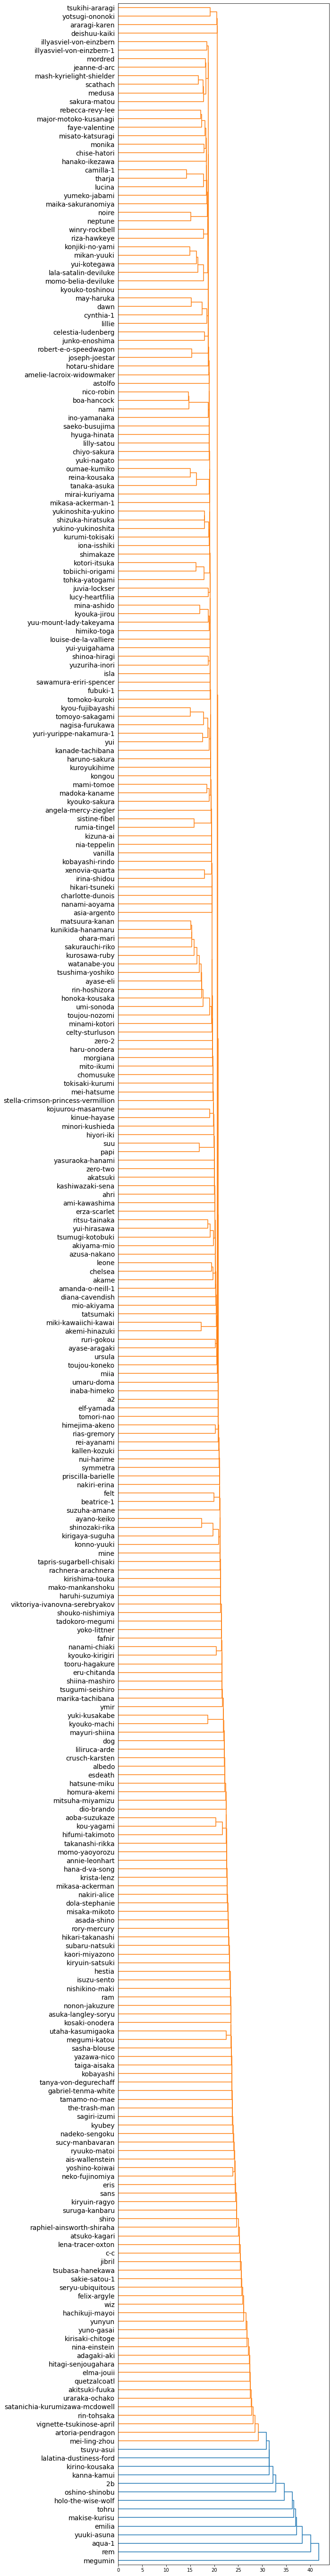

In [7]:
waifus = df.pop('waifu')
clusters = linkage(df)
plot_dendrogram(clusters, waifus.values)

In [8]:
json.dump(to_json(clusters), open('../data/d3-dendrogram.json', 'w'), sort_keys=True, indent=2)